# 🧠 Brain Tumor Detection System  

## 📂 Project Overview  
Brain tumor detection is crucial for early diagnosis and treatment planning. This project implements a convolutional neural network (CNN) to classify MRI images into four categories:  
- **No Tumor**  
- **Pituitary Tumor**  
- **Meningioma Tumor**  
- **Glioma Tumor**  

This notebook demonstrates end-to-end development, including data preprocessing, model training, evaluation, and visualization of results.  



## 📦 Importing Libraries  
In this section, we import all necessary libraries for:  
- **Data Handling:** `os`, `numpy`, `random`, `sklearn.utils.shuffle`  
- **Image Processing:** `PIL`, `tensorflow.keras.preprocessing.image`  
- **Model Development:** `tensorflow.keras` (for layers, model, VGG16), `Adam` optimizer  
  


In [2]:
# For directory and file operations
import os  

# For numerical operations and handling image arrays
import numpy as np  

# For generating random values for augmentation
import random  

# For image processing and enhancement
from PIL import Image, ImageEnhance  

# For loading images
from tensorflow.keras.preprocessing.image import load_img  

# For building the model
from tensorflow.keras.models import Sequential  

# For defining model layers
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  

# For optimizer
from tensorflow.keras.optimizers import Adam  

# For using VGG16 model as a pre-trained model (Transfer Learning)
from tensorflow.keras.applications import VGG16  

# For shuffling the data
from sklearn.utils import shuffle  


## 📂 Loading and Shuffling Dataset  

In this section, we:  
- Define directories for **Training** and **Testing** datasets.  
- **Load** image file paths along with their respective **labels**.  
- Use **shuffling** to ensure the model does not learn any unintended patterns from ordered data.  



In [3]:
# Directories for training and testing data
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


## 🖼️ Visualizing Random Images from the Training Dataset  

- In this step, we randomly select **10 images** from the training dataset.  
- Images are displayed with their **corresponding labels** in a grid format.  
- This visualization helps in understanding the **data quality** and verifying the **class labels**.  

### ✅ **Why is this important?**  
- Ensures the **dataset quality** by checking for corrupted or misclassified images.  
- Helps in getting an initial **visual sense** of the data distribution.  


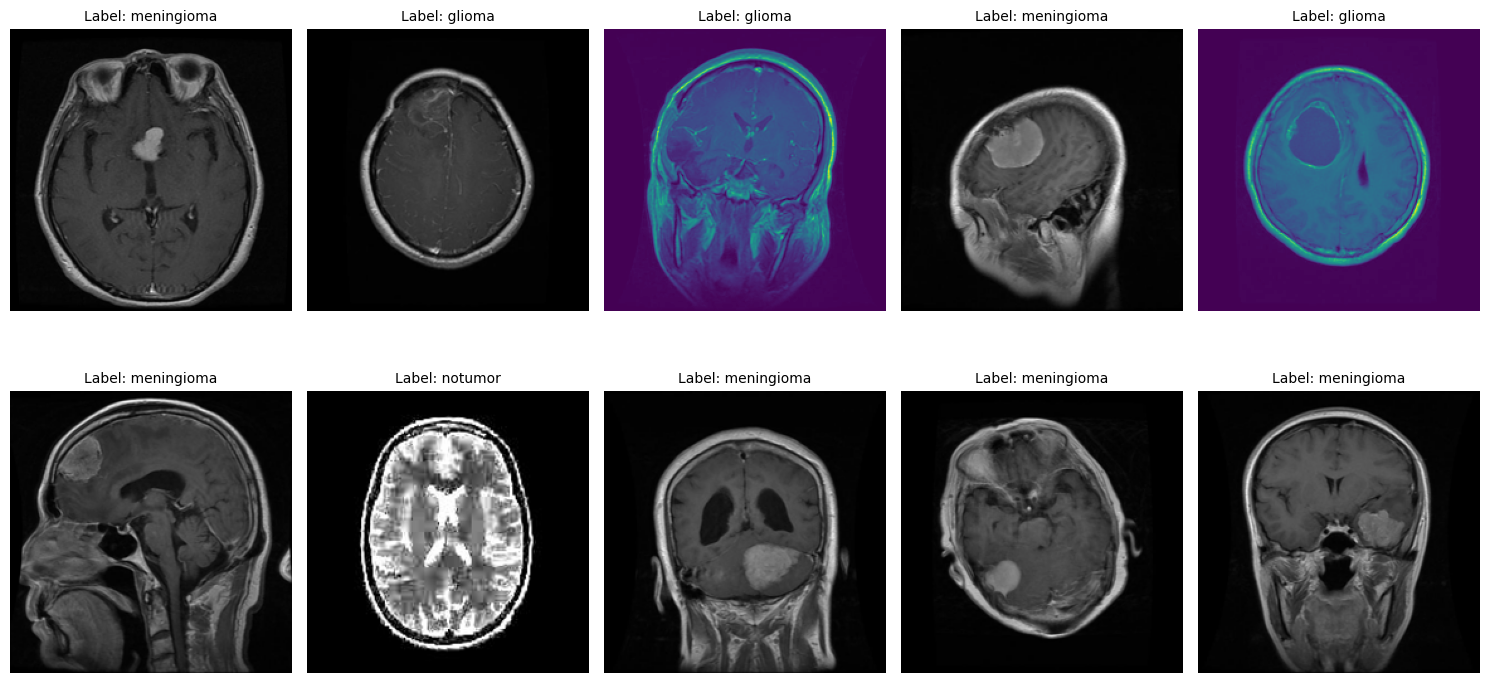

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

## **Image Preprocessing (Helper Functions)**

## 🎨 **Image Augmentation and Data Preparation**  

### 🧠 **What is Image Augmentation?**  
- Image augmentation enhances the diversity of the training dataset by applying **random transformations** to images.  
- It helps improve the **generalization** of the model by simulating **real-world variations**.  

### 🛠️ **Implemented Techniques:**  
- **Brightness Variation:** Randomly adjusts image brightness within a range of 0.8 to 1.2.  
- **Contrast Adjustment:** Randomly modifies contrast in the same range.  
- **Normalization:** Scales pixel values to **[0, 1]** to stabilize the model training process.  

### 📦 **Batch Data Generator:**  
- A custom **data generator** is implemented to efficiently load and augment data in **batches**.  
- Supports **on-the-fly image augmentation** and **label encoding**, suitable for large datasets.  

### 🟢 **Benefits:**  
- Reduces the risk of **overfitting** by training the model on a **varied dataset**.  
- Helps in maintaining a **balanced class representation** during each epoch.  


In [5]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

## **MODEL:**
**WE ARE USING VGG16 FOR TRANSFER LEARNING.**

## 🧠 **Why VGG16?**  
- **VGG16** is a powerful **Convolutional Neural Network (CNN)** pre-trained on **ImageNet**, a large dataset with **1.4 million images** and **1000 classes**.  
- Transfer learning with VGG16 helps leverage **pre-learned image features**, enabling faster and more accurate model training, especially for smaller datasets.  

---

### 📋 **Key Steps in the Model Setup:**  

1. **Load Pre-trained VGG16:**  
   - **Input Shape:** `(IMAGE_SIZE, IMAGE_SIZE, 3)` where `IMAGE_SIZE = 128`.  
   - **Include Top:** `False` to exclude the **fully connected layers** of VGG16.  
   - **Weights:** `'imagenet'` to load **pre-trained weights**.  

2. **Freezing Layers:**  
   - All layers are **frozen initially** to preserve the **pre-trained weights**.  
   - Only the **last three layers** are **set to trainable** for fine-tuning:  
     - `base_model.layers[-2].trainable = True`  
     - `base_model.layers[-3].trainable = True`  
     - `base_model.layers[-4].trainable = True`  

3. **Model Building Steps:**  
   - `Flatten()` layer reshapes the **3D tensor** output from VGG16 to **1D**.  
   - Two `Dropout` layers (**0.3** and **0.2**) reduce **overfitting** by randomly deactivating neurons during training.  
   - The final `Dense` layer with **softmax** activation outputs a **probability distribution** for the **classification task**.  

---




## 🚀 Model Architecture with VGG16 for Transfer Learning

In [ ]:
# Image size and base model setup
IMAGE_SIZE = 128  
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last three layers for fine-tuning
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # Input layer
    base_model,                                 # Pre-trained VGG16 base
    Flatten(),                                  # Flatten for dense layers
    Dropout(0.3),                               # Dropout to reduce overfitting
    Dense(128, activation='relu'),              # Fully connected layer with ReLU
    Dropout(0.2),                               # Additional dropout layer
    Dense(len(os.listdir(train_dir)), activation='softmax')  # Output layer
])

# Compile the model with Adam optimizer and sparse categorical loss
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Training parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Model training with data generator
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
203/285 ━━━━━━━━━━━━━━━━━━━━ 25s 308ms/step - loss: 0.7333 - sparse_categorical_accuracy: 0.7086

In [ ]:
model.save('brain_tumor_model.h5')


## **Train and Val Plots**

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## **Model Classification Report**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

## **Model Confusion Plot**

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## **Roc Curve Plot**

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## **Save & Load Model**

In [ ]:
# Save the entire model
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [ ]:
import os
os.listdir()


In [ ]:
from IPython.display import FileLink

# Generate a download link
FileLink('brain_tumor_model.h5')


## **MRI Tumor Detection System**

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [ ]:
# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [ ]:
# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [ ]:
# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0004.jpg'  
detect_and_display(image_path, model)

<a name="conclusion"></a>

<a name="conclusion"></a>